In [1]:
from keras.datasets import boston_housing 
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

ModuleNotFoundError: No module named 'keras'

In [2]:
print(train_data.shape,test_data.shape)

(404, 13) (102, 13)


In [3]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [4]:
## 数据标准化,减去均值，
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std 
test_data -= mean
test_data /= std

In [5]:
from keras import models
from keras import layers 
def build_model():
     model = models.Sequential() 
     model.add(layers.Dense(64, activation='relu',
     input_shape=(train_data.shape[1],)))
     model.add(layers.Dense(64, activation='relu'))
     model.add(layers.Dense(1))
     model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
     return model

In [6]:
##### K折交叉数据分割
import numpy as np 
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = [] 
for i in range(k):
     print('processing fold #', i)
     val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
     val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples] 
    
     partial_train_data = np.concatenate( 
         [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]], 
         axis=0)
    
     partial_train_targets = np.concatenate(
         [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]], 
         axis=0) 
    
     model = build_model() 
     model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
     val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0) 
     all_scores.append(val_mae) 


processing fold # 0


KeyboardInterrupt: 

In [32]:
all_scores

[2.2763936519622803, 2.630625009536743, 2.624013662338257, 2.298398017883301]

In [33]:
np.mean(all_scores)

2.4573575854301453

In [46]:
num_epochs = 500 
all_mae_histories = [] 
for i in range(k):
     print('processing fold #', i)
     val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
     val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples] 
 
     partial_train_data = np.concatenate( 
         [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]], 
         axis=0) 

     partial_train_targets = np.concatenate(
         [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
         axis=0) 

     model = build_model() 
     history = model.fit(partial_train_data, partial_train_targets, 
                         validation_data=(val_data, val_targets),
                         epochs=num_epochs, batch_size=1, verbose=0)
    
     mae_history = history.history['val_mae']
     all_mae_histories.append(mae_history) 

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


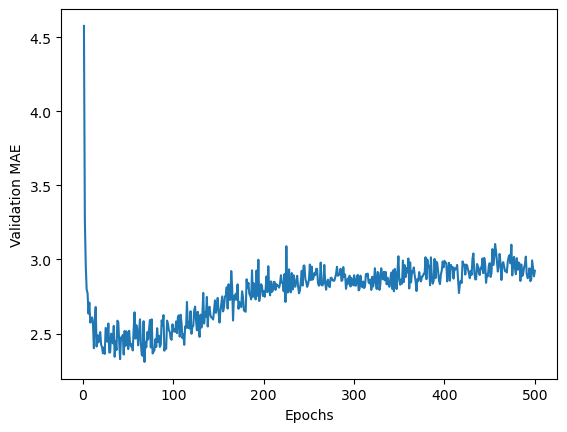

In [47]:
average_mae_history = [
 np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]


import matplotlib.pyplot as plt 
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

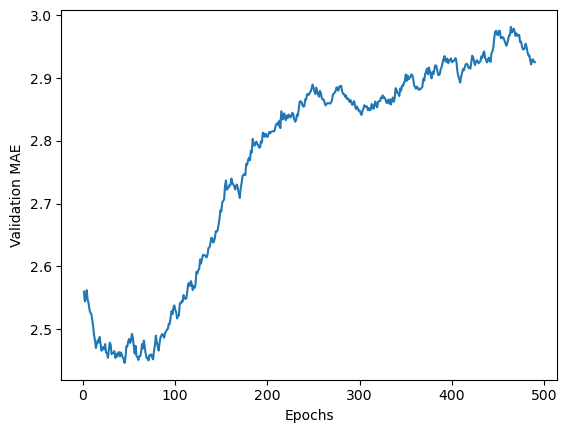

In [52]:
def smooth_curve(points, factor=0.9):
 smoothed_points = []
 for point in points:
     if smoothed_points:
         previous = smoothed_points[-1]
         smoothed_points.append(previous * factor + point * (1 - factor))
     else:
         smoothed_points.append(point)
 return smoothed_points 
     
smooth_mae_history = smooth_curve(average_mae_history[10:]) 
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()